This is an attempt at a tutorial just for orbital and frame analysis for Solar Orbiter and Parker Solar Probe using SunPy (initially for Steffie, but modified quickly to include STEREO A,B data (/transforming frames from other data) for Kaja)

Prior to this you'll need a modern installation of SunPy (tested on on ver 7.0.3) and also you might need to update the python OpenSSL package if an error arises

In [1]:
import sunpy 
import astropy
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cdflib 
import sunpy_soar

c:\Users\jw12518\AppData\Local\miniconda3\envs\CondaSun\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Orbits!
we'll need to consider the orbit of solar orbiter during this time as well;  In 2022 I used astrospice which is now depreciated


it can also be done by using the Horizons or something https://ssd.jpl.nasa.gov/horizons/ -  contact YuFei for help in this situation 


using SPICE kernels following https://docs.sunpy.org/en/stable/generated/gallery/units_and_coordinates/spice.html

In [2]:
# we need to define times of interest

import datetime
#e.g. just under a month of time, taken at timesteps of 1 hour using datetimes. 
times = np.arange(datetime.datetime(year = 2022,month = 2, day = 8), datetime.datetime(2022, 3,5), datetime.timedelta(hours = 1))

# the frame transformation to the Heliographic Carrington frame of reference (this is the longitude of the spacecraft relative to the Sun's rotation)
HeliographicCarrington = sunpy.coordinates.HeliographicCarrington(observer='self') 
HeliographicStonyhurst = sunpy.coordinates.HeliographicStonyhurst()

<div class="alert alert-block alert-info">
Sunpy has its own inbuilt frames of reference for transforming to, sometimes these are good and sometimes not. I've not had any trouble with the Heliographic transforms, but I use the SPICE kernels to transform into GSE coordinates because the built-in GSM coordinate transform was not working well. 

<b>Always plot your data to see if things are going as you'd expect!</b>

Getting started with SPICE kernels using sunpy: it's surprisingly easy!
- https://psp-gateway.jhuapl.edu/website/Ancillary/SclkFiles has a great format for understanding what you can get out of each SPICE kernel
- 'http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/ is the https to the data files of the Solar Orbiter kernels, it looks arcane but each folder has a readme which tells you what you will get out

Not all of the kernels loaded above are necessary for this simple orbital analysis, but when in doubt, finding an applicable metakernel will help navigate the kernels needed for a given time frame.
e.g. here we don't require the frame kernels (fk) for the instruments or spacecraft frame, 

In [3]:
#using spice to get the coordinates
# download the SPICE kernels
# the solar orbiter kernels are located here
# not super duper important to be honest

from sunpy.data import cache
from sunpy.coordinates import spice

# SolO kernels to load taken from the metakernel at http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/mk
# these kernels are over the top because they include the instrument frames and FOV transformations
SolObase_url = f'http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/'
KERNELS_TO_LOAD   = [
                           'ck/solo_ANC_soc-sc-iboom-ck_20180930-21000101_V02.bc',
                           'ck/solo_ANC_soc-sc-oboom-ck_20180930-21000101_V02.bc',
                           'ck/solo_ANC_soc-sc-fof-ck_20180930-21000101_V03.bc',
                           'ck/solo_ANC_soc-eui-fsi-ck_20180930-21000101_V04.bc',
                           'ck/solo_ANC_soc-eui-hri-euv-ck_20180930-21000101_V04.bc',
                           'ck/solo_ANC_soc-eui-hri-lya-ck_20180930-21000101_V04.bc',
                           'ck/solo_ANC_soc-metis-euv-ck_20180930-21000101_V03.bc',
                           'ck/solo_ANC_soc-metis-vis-ck_20180930-21000101_V03.bc',
                           'ck/solo_ANC_soc-metis-m0-tel-ck_20180930-21000101_V03.bc',
                           'ck/solo_ANC_soc-phi-fdt-ck_20180930-21000101_V03.bc',
                           'ck/solo_ANC_soc-phi-hrt-ck_20180930-21000101_V03.bc',
                           'ck/solo_ANC_soc-solohi-ck_20180930-21000101_V04.bc',
                           'ck/solo_ANC_soc-spice-sw-ck_20180930-21000101_V04.bc',
                           'ck/solo_ANC_soc-spice-lw-ck_20180930-21000101_V04.bc',
                           'ck/solo_ANC_soc-stix-ck_20180930-21000101_V03.bc',
                           'ck/solo_ANC_soc-default-att_20200210-20301120_L019_V1_00387_V01.bc',
                           'ck/solo_ANC_soc-default-att-stp_20200210-20301120_338_V1_00401_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20210816-20210920_L006_V1_M04_V02_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20211013-20211204_L006_V1_M05_V02_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20220902-20301120_L009_V1_M08_V01_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20220930-20301120_L010_V1_M09_V02_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20230319-20301120_L011_V1_M11_V01_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20230929-20301120_L014_V1_M13_V01_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20240125-20301120_L015_V1_M14_V01_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20240430-20301120_L016_V1_M15_V02_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20240705-20301120_L017_V1_M16_V02_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20240705-20301120_L018_V1_M16_V03_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20241206-20301120_L018_V1_M17_V02_V01.bc',
                           'ck/solo_ANC_soc-pred-roll-att_20250117-20301120_L019_V1_M18_V01_V01.bc',
                           'ck/solo_ANC_soc-pred-att_20200210_20241216_S338_V1_00401_V01.bc',

                           'fk/solo_ANC_soc-sc-fk_V09.tf',
                           'fk/solo_ANC_soc-ops-fk_V02.tf',
                           'fk/solo_ANC_soc-sci-fk_V08.tf',
                           'fk/earth_topo_050714.tf',
                           'fk/estrack_v04.tf',

                           'ik/solo_ANC_soc-epd-ik_V03.ti',
                           'ik/solo_ANC_soc-eui-ik_V01.ti',
                           'ik/solo_ANC_soc-metis-ik_V03.ti',
                           'ik/solo_ANC_soc-phi-ik_V01.ti',
                           'ik/solo_ANC_soc-solohi-ik_V01.ti',
                           'ik/solo_ANC_soc-spice-ik_V02.ti',
                           'ik/solo_ANC_soc-stix-ik_V02.ti',
                           'ik/solo_ANC_soc-swa-ik_V03.ti',

                           'lsk/naif0012.tls',

                           'pck/pck00010.tpc',

                           'pck/earth_070425_370426_predict.bpc',

                           'sclk/solo_ANC_soc-sclk-fict_20000101_V01.tsc',

                           'spk/solo_ANC_soc-orbit_20200210-20301120_L019_V1_00387_V01.bsp',
                           'spk/solo_ANC_soc-orbit-stp_20200210-20301120_338_V1_00401_V01.bsp',
                           'spk/de421.bsp',
                           'spk/earthstns_itrf93_050714.bsp',
                           'spk/estrack_v04.bsp',
                           'spk/earthnpole_19500101_20251231_v01.bsp'
]

solokernelurl = [f'http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/{url}' for url in KERNELS_TO_LOAD]
solokernelurl.append(f'https://spdf.gsfc.nasa.gov/pub/data/psp/ephemeris/spice/reconstructed_ephemeris/spp_recon_20211217_20220329_v001.bsp') # this finds the parker solar probe reconstructed SPICE kernel between 2021,12,17 to 2022,03,29 ; just right for this example time period
# there are ways to download and initialize all the parker solar probe kernels at once, which involve scraping all of the kernels from the folder

SolOkernel_files = [cache.download(url) for url in solokernelurl]

spice.initialize(SolOkernel_files)




ImportError: cannot import name 'spice' from 'sunpy.coordinates' (c:\Users\jw12518\AppData\Local\miniconda3\envs\CondaSun\lib\site-packages\sunpy\coordinates\__init__.py)

sunpy.coordinates.spice.initialize does a lot of the leg work of furnsh(kernels) and loading information from there

In [ ]:
#to scroll through the frames that have just been downloaded, check the frame registry
spice._frame_registry

{'SOLO_IAU_SUN_2003': (abc.spice_SOLO_IAU_SUN_2003, abc._spice_center_10),
 'SOLO_IAU_SUN_2009': (abc.spice_SOLO_IAU_SUN_2009, abc._spice_center_10),
 'SOLO_STIX_ILS': (abc.spice_SOLO_STIX_ILS, abc._spice_center_n144),
 'SOLO_SPICE_LW_ILS': (abc.spice_SOLO_SPICE_LW_ILS, abc._spice_center_n144),
 'SOLO_SPICE_SW_ILS': (abc.spice_SOLO_SPICE_SW_ILS, abc._spice_center_n144),
 'SOLO_SOLOHI_ILS': (abc.spice_SOLO_SOLOHI_ILS, abc._spice_center_n144),
 'SOLO_PHI_HRT_ILS': (abc.spice_SOLO_PHI_HRT_ILS, abc._spice_center_n144),
 'SOLO_PHI_FDT_ILS': (abc.spice_SOLO_PHI_FDT_ILS, abc._spice_center_n144),
 'SOLO_METIS_M0_TEL': (abc.spice_SOLO_METIS_M0_TEL, abc._spice_center_n144),
 'SOLO_METIS_IEO-M0': (abc.spice_SOLO_METIS_IEOnM0, abc._spice_center_n144),
 'SOLO_METIS_VIS_ILS': (abc.spice_SOLO_METIS_VIS_ILS, abc._spice_center_n144),
 'SOLO_METIS_EUV_ILS': (abc.spice_SOLO_METIS_EUV_ILS, abc._spice_center_n144),
 'SOLO_EUI_HRI_EUV_ILS': (abc.spice_SOLO_EUI_HRI_EUV_ILS,
  abc._spice_center_n144),
 'SOLO_

In [ ]:
SPICESolOrbit = spice.get_body('Solar Orbiter', times, ) # create the orbit data from the SPICE kernels at the times defined
SPICEPSPorbit = spice.get_body('Parker Solar Probe', times, )

In [ ]:
SPICESolOrbit =SPICESolOrbit.transform_to(HeliographicCarrington) # we put them in the heliographic carrington coordinate system - decide for yourself if this is what you want
SPICEPSPorbit =SPICEPSPorbit.transform_to(HeliographicCarrington)

In [ ]:
SPICESolOrbitdf = pd.DataFrame({'radius':SPICESolOrbit.radius.to(astropy.units.AU), 'lon':SPICESolOrbit.lon, 'lat':SPICESolOrbit.lat}, index = SPICESolOrbit.obstime) # make dataframes 
SPICEPSPorbitdf = pd.DataFrame({'radius':SPICEPSPorbit.radius.to(astropy.units.AU), 'lon':SPICEPSPorbit.lon, 'lat':SPICEPSPorbit.lat}, index = SPICEPSPorbit.obstime)

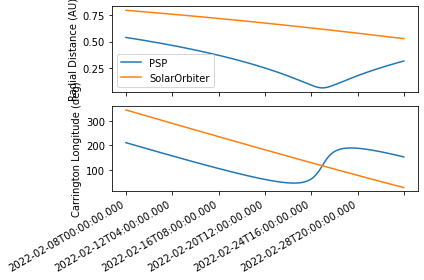

In [ ]:
fig,ax = plt.subplots(2,1,layout = 'tight',  figsize = (10,10))

SPICEPSPorbitdf.radius.plot(ax = ax[0], label = 'PSP')
SPICESolOrbitdf.radius.plot(ax = ax[0], label = 'SolarOrbiter')
ax[0].legend()
ax[0].set_ylabel('Radial Distance (AU)')

SPICEPSPorbitdf.lon.plot(ax = ax[1])
SPICESolOrbitdf.lon.plot(ax = ax[1])
ax[1].set_ylabel('Carrington Longitude (deg)')
plt.gcf().autofmt_xdate()

Text(0.5, 1.0, 'Orbits Relative to the Surface of the Sun')

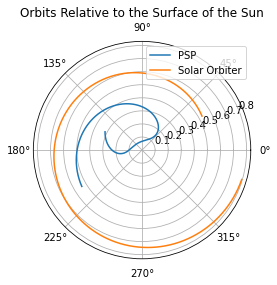

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},  figsize = (10,10))
ax.plot(SPICEPSPorbitdf.lon * np.pi / 180 , SPICEPSPorbitdf.radius, label = 'PSP')
ax.plot(SPICESolOrbitdf.lon * np.pi / 180 , SPICESolOrbitdf.radius, label = 'Solar Orbiter')
ax.legend()
plt.title('Orbits Relative to the Surface of the Sun' )

the code here follows the tutorials online at https://github.com/SolarOrbiterWorkshop/solo8_tutorials/blob/main/sunpy_tutorial/sunpy_tutorial.ipynb and uses JPL Horizons for the coordinates


now includes the STEREO orbits adapted from https://docs.sunpy.org/en/stable/generated/gallery/showcase/where_is_stereo.html

In [ ]:
#using Horizons to get the coordinates in a default reference frame (J2000) - it should possible to get these coordinates in any reference frame, and we will test this later
HORIZONSSolOrbit = sunpy.coordinates.get_horizons_coord('solar orbiter', times)
HORIZONSPSPorbit = sunpy.coordinates.get_horizons_coord('psp', times)
orbitSTEREOA    =  sunpy.coordinates.get_horizons_coord('STEREO-A', times)
orbitSTEREOB    =  sunpy.coordinates.get_horizons_coord('STEREO-B', times)

#transforming from whatever initial reference frame into the Heliographic Carrington frame
HORIZONSSolOrbit = HORIZONSSolOrbit.transform_to(HeliographicCarrington)
HORIZONSPSPorbit = HORIZONSPSPorbit.transform_to(HeliographicCarrington)
orbitSTEREOA    =  orbitSTEREOA.transform_to(HeliographicCarrington)
orbitSTEREOB    =  orbitSTEREOB.transform_to(HeliographicCarrington)

# I tend to personally move all of my data into pandas dataframes, because they're more general than direct sunpy.timeseries.Timeseries objects, but maybe this isn't the best way to work  
HORIZONSSolOrbitdf = pd.DataFrame({'radius':HORIZONSSolOrbit.radius.to(astropy.units.AU), 'lon':HORIZONSSolOrbit.lon, 'lat':HORIZONSSolOrbit.lat}, index = HORIZONSSolOrbit.obstime) # make dataframes 
HORIZONSPSPorbitdf = pd.DataFrame({'radius':HORIZONSPSPorbit.radius.to(astropy.units.AU), 'lon':HORIZONSPSPorbit.lon, 'lat':HORIZONSPSPorbit.lat}, index = HORIZONSPSPorbit.obstime)
orbitSTEREOAdf    =  pd.DataFrame({'radius':orbitSTEREOA.radius.to(astropy.units.AU), 'lon':orbitSTEREOA.lon, 'lat':orbitSTEREOA.lat}, index = orbitSTEREOA.obstime)
orbitSTEREOBdf    =  pd.DataFrame({'radius':orbitSTEREOB.radius.to(astropy.units.AU), 'lon':orbitSTEREOB.lon, 'lat':orbitSTEREOB.lat}, index = orbitSTEREOB.obstime)


2025-10-31 05:34:23 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144)


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144) [sunpy.coordinates.ephemeris]


2025-10-31 05:34:25 - sunpy - INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) (-96)


INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) (-96) [sunpy.coordinates.ephemeris]


2025-10-31 05:34:26 - sunpy - INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234)   


INFO: Obtained JPL HORIZONS location for STEREO-A (spacecraft) (-234)    [sunpy.coordinates.ephemeris]


2025-10-31 05:34:27 - sunpy - INFO: Obtained JPL HORIZONS location for STEREO-B (spacecraft) (-235)   


INFO: Obtained JPL HORIZONS location for STEREO-B (spacecraft) (-235)    [sunpy.coordinates.ephemeris]


let's also grab the Earth while we're here

In [ ]:
#planetary bodies have a default reference frame of Heliographic Stonyhurst (Sun - Earth line is 0 longitude)
earth_coords = sunpy.coordinates.get_earth(times)
earth_coords = earth_coords.transform_to(HeliographicCarrington)

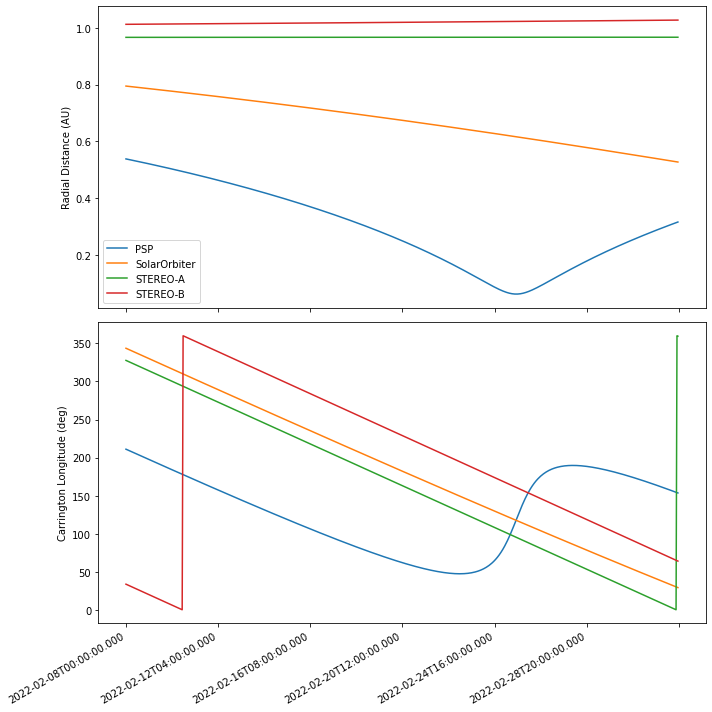

In [ ]:
fig,ax = plt.subplots(2,1,layout = 'tight', figsize = (10,10))

HORIZONSPSPorbitdf.radius.plot(ax = ax[0], label = 'PSP')
HORIZONSSolOrbitdf.radius.plot(ax = ax[0], label = 'SolarOrbiter')
orbitSTEREOAdf.radius.plot(ax = ax[0], label = 'STEREO-A')
orbitSTEREOBdf.radius.plot(ax = ax[0], label = 'STEREO-B')
ax[0].legend()
ax[0].set_ylabel('Radial Distance (AU)')

HORIZONSPSPorbitdf.lon.plot(ax = ax[1])
HORIZONSSolOrbitdf.lon.plot(ax = ax[1])
orbitSTEREOAdf.lon.plot(ax = ax[1], label = 'STEREO-A')
orbitSTEREOBdf.lon.plot(ax = ax[1], label = 'STEREO-B')
ax[1].set_ylabel('Carrington Longitude (deg)')
plt.gcf().autofmt_xdate()

Text(0.5, 1.0, 'Orbits Relative to the Rotating Surface of the Sun')

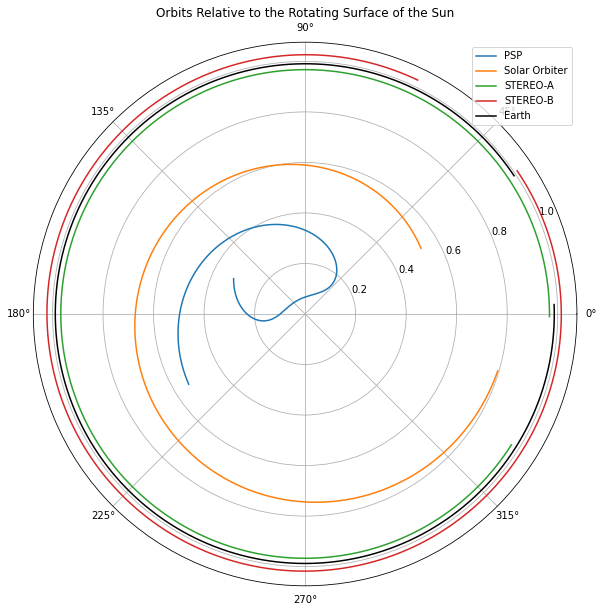

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},  figsize = (10,10))
ax.plot(HORIZONSPSPorbitdf.lon * np.pi / 180 , HORIZONSPSPorbitdf.radius, label = 'PSP')
ax.plot(HORIZONSSolOrbitdf.lon * np.pi / 180 , HORIZONSSolOrbitdf.radius, label = 'Solar Orbiter')
ax.plot(orbitSTEREOAdf.lon * np.pi / 180 , orbitSTEREOAdf.radius, label = 'STEREO-A')
ax.plot(orbitSTEREOBdf.lon * np.pi / 180 , orbitSTEREOBdf.radius, label = 'STEREO-B')
ax.plot(earth_coords.lon * np.pi/180, earth_coords.radius, color = 'k', label = 'Earth')

ax.legend()
plt.title('Orbits Relative to the Rotating Surface of the Sun' )

this could all be viewed in Heliographic Stonyhurst

Text(0.5, 1.0, 'Orbits Relative to the Sun-Earth line')

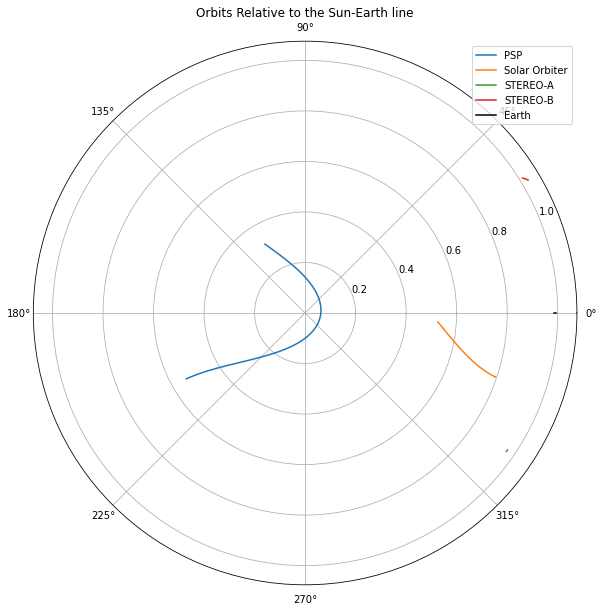

In [ ]:
HORIZONSSolOrbit = HORIZONSSolOrbit.transform_to(HeliographicStonyhurst)
HORIZONSPSPorbit = HORIZONSPSPorbit.transform_to(HeliographicStonyhurst)
orbitSTEREOA    =  orbitSTEREOA.transform_to(HeliographicStonyhurst)
orbitSTEREOB    =  orbitSTEREOB.transform_to(HeliographicStonyhurst)
earth_coords = earth_coords.transform_to(HeliographicStonyhurst)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},  figsize = (10,10))
ax.plot(HORIZONSPSPorbit.lon * np.pi / 180 , HORIZONSPSPorbit.radius, label = 'PSP')
ax.plot(HORIZONSSolOrbit.lon * np.pi / 180 , HORIZONSSolOrbit.radius, label = 'Solar Orbiter')
ax.plot(orbitSTEREOA.lon * np.pi / 180 , orbitSTEREOA.radius, label = 'STEREO-A')
ax.plot(orbitSTEREOB.lon * np.pi / 180 , orbitSTEREOB.radius, label = 'STEREO-B')
ax.plot(earth_coords.lon * np.pi/180, earth_coords.radius, color = 'k', label = 'Earth')

ax.legend()
plt.title('Orbits Relative to the Sun-Earth line' )

or can plot on in cartesian coordinates more similarly to https://docs.sunpy.org/en/stable/generated/gallery/showcase/where_is_stereo.html (But not necessarily in the HEE frame)

Text(0, 0.5, 'y (AU)')

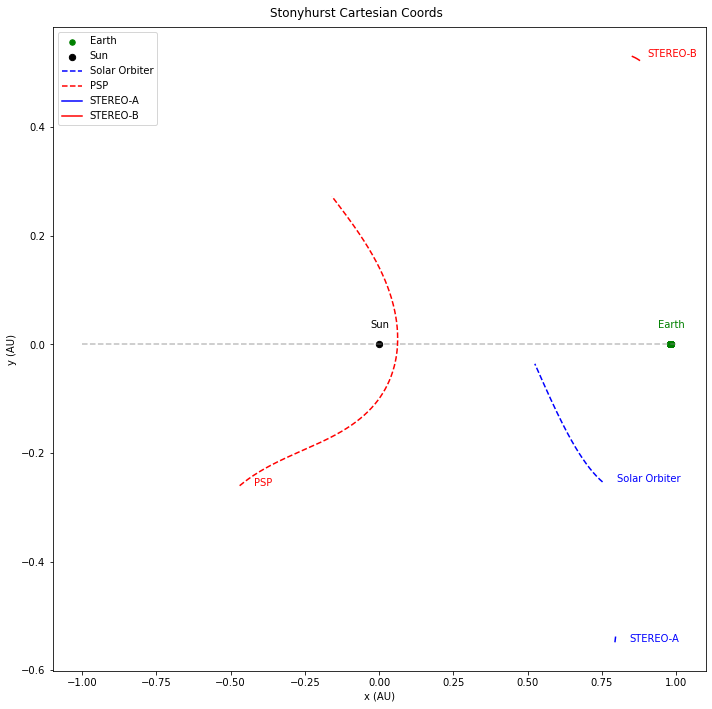

In [ ]:
HORIZONSSolOrbit.representation_type = 'cartesian'
HORIZONSPSPorbit.representation_type = 'cartesian'
orbitSTEREOA.representation_type = 'cartesian'    
orbitSTEREOB.representation_type = 'cartesian'    
earth_coords.representation_type = 'cartesian'

fig, ax = plt.subplots(layout = 'tight', figsize = (10,10))
ax.scatter(earth_coords.x.to_value('AU'), earth_coords.y.to_value('AU'), c = 'green', s = 30, label = 'Earth')
ax.text(earth_coords.x.to_value('AU')[0]-0.04, earth_coords.y.to_value('AU')[0]+0.03, 'Earth', c = 'green', )

ax.scatter(0,0,c = 'k', s = 40, label = 'Sun')
ax.text(-0.03,0.03, 'Sun', c = 'k',)
ax.hlines(0,-1,1,color = 'grey', linestyle = '--', alpha = 0.5)


for coords, color, linestyle, label in [[HORIZONSSolOrbit, 'blue', '--', 'Solar Orbiter',],[HORIZONSPSPorbit, 'red', '--', 'PSP'],[orbitSTEREOA,'blue','-','STEREO-A'],[orbitSTEREOB, 'red', '-' , 'STEREO-B']]:
    ax.plot(coords.x.to_value('AU'), coords.y.to_value('AU'), c = color, linestyle = linestyle, label = label)#
    ax.text(coords.x.to_value('AU')[0] + 0.05, coords.y.to_value('AU')[0], label,c = color, )

ax.legend()
fig.suptitle('Stonyhurst Cartesian Coords')
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')

At a bit of a stretch, you could get these in GSM coordinates as well (and any other supported or SPICE derived Frame)

In [ ]:
#spice_SOLO_GSE is the GSE frame that was constructed from the SPICE kernels at the beginning of this notebook

HORIZONSSolOrbit = HORIZONSSolOrbit.transform_to('spice_SOLO_GSE')
HORIZONSPSPorbit = HORIZONSPSPorbit.transform_to('spice_SOLO_GSE')
orbitSTEREOA    =  orbitSTEREOA.transform_to('spice_SOLO_GSE')
orbitSTEREOB    =  orbitSTEREOB.transform_to('spice_SOLO_GSE')
earth_coords = earth_coords.transform_to('spice_SOLO_GSE')


Text(0, 0.5, 'y (AU)')

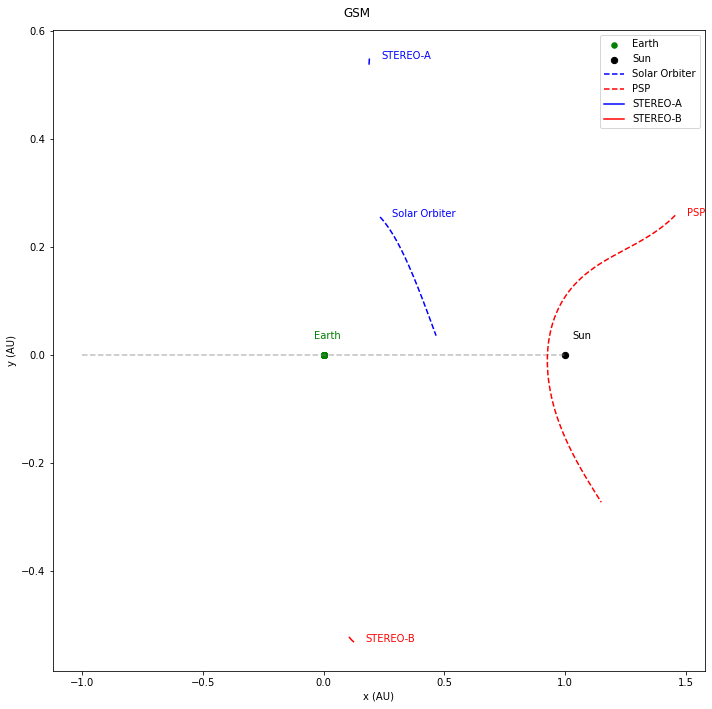

In [ ]:
HORIZONSSolOrbit.representation_type = 'cartesian'
HORIZONSPSPorbit.representation_type = 'cartesian'
orbitSTEREOA.representation_type = 'cartesian'    
orbitSTEREOB.representation_type = 'cartesian'    
earth_coords.representation_type = 'cartesian'

fig, ax = plt.subplots(layout = 'tight', figsize = (10,10))
ax.scatter(earth_coords.x.to_value('AU'), earth_coords.y.to_value('AU'), c = 'green', s = 30, label = 'Earth')
ax.text(earth_coords.x.to_value('AU')[0]-0.04, earth_coords.y.to_value('AU')[0]+0.03, 'Earth', c = 'green', )

ax.scatter(1,0,c = 'k', s = 40, label = 'Sun')
ax.text(1.03,0.03, 'Sun', c = 'k',)
ax.hlines(0,-1,1,color = 'grey', linestyle = '--', alpha = 0.5)


for coords, color, linestyle, label in [[HORIZONSSolOrbit, 'blue', '--', 'Solar Orbiter',],[HORIZONSPSPorbit, 'red', '--', 'PSP'],[orbitSTEREOA,'blue','-','STEREO-A'],[orbitSTEREOB, 'red', '-' , 'STEREO-B']]:
    ax.plot(coords.x.to_value('AU'), coords.y.to_value('AU'), c = color, linestyle = linestyle, label = label)#
    ax.text(coords.x.to_value('AU')[0] + 0.05, coords.y.to_value('AU')[0], label,c = color, )

ax.legend()
fig.suptitle('GSM')
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')

Then the step to working with timeseries data is interpolating the orbit data into the relevant time indices that you have your data in

In [ ]:
#and then  you'll want to interpolate these to the data frame as well - the best way to do this is to unwrap the longitude and latitude so that you're not risking unreal movements 
# for example you could see if any data is crossing over the 360 - 0 degrees boundary
print(SPICESolOrbitdf.loc[np.abs(SPICESolOrbitdf.lon.diff()) > 180]) 
#if this isn't empty then you'll need to do something about it, depending on which way the spacecraft have gone over the boundary
 

Empty DataFrame
Columns: [radius, lon, lat]
Index: []


In [ ]:
#for example
test = pd.DataFrame({'lon':[100,50,00,310,260,210]}, index = [0,1,2,3,4,5])
test.loc[np.abs(test.lon.diff()).idxmax()] # where is the discontinuity?
test.lon.loc[test.index >= np.abs(test.lon.diff()).idxmax()] -= 360

targetdf = pd.DataFrame({}, index = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
newlon = np.interp(targetdf.index, test.index, test.lon)
targetdf['newlon'] = newlon % 360

Text(0, 0.5, 'interpolated longitudes')

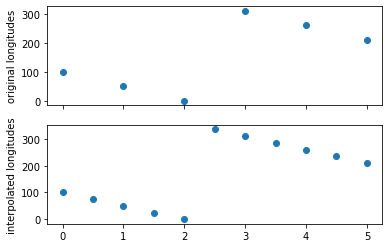

In [ ]:
fig, ax = plt.subplots(2,1, sharex = True)
ax[0].scatter(test.index , test.lon%360)
ax[0].set_ylabel('original longitudes')

ax[1].scatter(targetdf.index, targetdf.newlon)
ax[1].set_ylabel('interpolated longitudes')

